# Structured data classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/06/09<br>
**Last modified:** 2020/06/09<br>
**Description:** Binary classification of structured data including numerical and categorical features.

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Preparing the data

Let's download the data and load it into a Pandas dataframe:

In [170]:
file_url = "Wine.csv"
dataframe = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [4]:
dataframe.shape

(178, 14)

Here's a preview of a few samples:

In [5]:
dataframe.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1




Let's split the data into a training and validation set:

In [171]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 142 samples for training and 36 for validation


Let's generate `tf.data.Dataset` objects for each dataframe:

In [172]:
from tensorflow.keras.utils import to_categorical
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Customer_Segment")
    #labels = to_categorical(labels)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [125]:
labels = dataframe["Customer_Segment"]
labels = tf.one_hot(labels, 3)
labels

<tf.Tensor: shape=(178, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
     

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

In [173]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Alcohol': <tf.Tensor: shape=(), dtype=float64, numpy=14.38>, 'Malic_Acid': <tf.Tensor: shape=(), dtype=float64, numpy=1.87>, 'Ash': <tf.Tensor: shape=(), dtype=float64, numpy=2.38>, 'Ash_Alcanity': <tf.Tensor: shape=(), dtype=float64, numpy=12.0>, 'Magnesium': <tf.Tensor: shape=(), dtype=int64, numpy=102>, 'Total_Phenols': <tf.Tensor: shape=(), dtype=float64, numpy=3.3>, 'Flavanoids': <tf.Tensor: shape=(), dtype=float64, numpy=3.64>, 'Nonflavanoid_Phenols': <tf.Tensor: shape=(), dtype=float64, numpy=0.29>, 'Proanthocyanins': <tf.Tensor: shape=(), dtype=float64, numpy=2.96>, 'Color_Intensity': <tf.Tensor: shape=(), dtype=float64, numpy=7.5>, 'Hue': <tf.Tensor: shape=(), dtype=float64, numpy=1.2>, 'OD280': <tf.Tensor: shape=(), dtype=float64, numpy=3.0>, 'Proline': <tf.Tensor: shape=(), dtype=int64, numpy=1547>}
Target: tf.Tensor(1, shape=(), dtype=int64)


Let's batch the datasets:

In [174]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

TypeError: ignored

## Feature preprocessing with Keras layers



In [175]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Build a model

With this done, we can create our end-to-end model:

In [156]:
dataframe.head().transpose()

,0,1,2,3,4
Alcohol,14.23,13.20,13.16,14.37,13.24
Malic_Acid,1.71,1.78,2.36,1.95,2.59
Ash,2.43,2.14,2.67,2.50,2.87
Ash_Alcanity,15.60,11.20,18.60,16.80,21.00
Magnesium,127.00,100.00,101.00,113.00,118.00
Total_Phenols,2.80,2.65,2.80,3.85,2.80
Flavanoids,3.06,2.76,3.24,3.49,2.69
Nonflavanoid_Phenols,0.28,0.26,0.30,0.24,0.39
Proanthocyanins,2.29,1.28,2.81,2.18,1.82
Color_Intensity,5.64,4.38,5.68,7.80,4.32


In [70]:
dataframe['Customer_Segment'].value_counts()

2    71
1    59
3    48
Name: Customer_Segment, dtype: int64

In [178]:
# Numerical features
Alcohol = keras.Input(shape=(1,), name="Alcohol", dtype="int64")
Malic_Acid = keras.Input(shape=(1,), name="Malic_Acid", dtype="int64")
Ash = keras.Input(shape=(1,), name="Ash", dtype="int64")
Ash_Alcanity = keras.Input(shape=(1,), name="Ash_Alcanity", dtype="int64")
Magnesium = keras.Input(shape=(1,), name="Magnesium", dtype="int64")
Total_Phenols = keras.Input(shape=(1,), name="Total_Phenols", dtype="int64")
Flavanoids = keras.Input(shape=(1,), name="Flavanoids", dtype="int64")
Nonflavanoid_Phenols = keras.Input(shape=(1,), name="Nonflavanoid_Phenols", dtype="int64")
Proanthocyanins = keras.Input(shape=(1,), name="Proanthocyanins", dtype="int64")
Color_Intensity = keras.Input(shape=(1,), name="Color_Intensity", dtype="int64")
Hue = keras.Input(shape=(1,), name="Hue", dtype="int64")
OD280 = keras.Input(shape=(1,), name="OD280", dtype="int64")
Proline = keras.Input(shape=(1,), name="Proline", dtype="int64")



all_inputs = [
    Alcohol,
    Malic_Acid,
    Ash,
    Ash_Alcanity,
    Magnesium,
    Total_Phenols,
    Flavanoids,
    Nonflavanoid_Phenols,
    Proanthocyanins,
    Color_Intensity,
    Hue,
    OD280,
    Proline,
]

# Numerical features
Alcohol_encoded = encode_numerical_feature(Alcohol, "Alcohol", train_ds)
Malic_Acid_encoded = encode_numerical_feature(Malic_Acid, "Malic_Acid", train_ds)
Ash_encoded = encode_numerical_feature(Ash, "Ash", train_ds)
Ash_Alcanity_encoded = encode_numerical_feature(Ash_Alcanity, "Ash_Alcanity", train_ds)
Magnesium_encoded = encode_numerical_feature(Magnesium, "Magnesium", train_ds)
Total_Phenols_encoded = encode_numerical_feature(Total_Phenols, "Total_Phenols", train_ds)
Flavanoids_encoded = encode_numerical_feature(Flavanoids, "Flavanoids", train_ds)
Nonflavanoid_Phenols_encoded = encode_numerical_feature(Nonflavanoid_Phenols, "Nonflavanoid_Phenols", train_ds)
Proanthocyanins_encoded = encode_numerical_feature(Proanthocyanins, "Proanthocyanins", train_ds)
Color_Intensity_encoded = encode_numerical_feature(Color_Intensity, "Color_Intensity", train_ds)
Hue_encoded = encode_numerical_feature(Hue, "Hue", train_ds)
OD280_encoded = encode_numerical_feature(OD280, "OD280", train_ds)
Proline_encoded = encode_numerical_feature(Proline, "Proline", train_ds)




all_features = layers.concatenate(
    [
        Alcohol_encoded,
        Malic_Acid_encoded,
        Ash_encoded,
        Ash_Alcanity_encoded,
        Magnesium_encoded,
        Total_Phenols_encoded,
     Flavanoids_encoded,
        Nonflavanoid_Phenols_encoded,
        Proanthocyanins_encoded,
        Color_Intensity_encoded,
        Hue_encoded,
        OD280_encoded,
        Proline_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(8, activation="relu")(x)
output = layers.Dense(4, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

Let's visualize our connectivity graph:

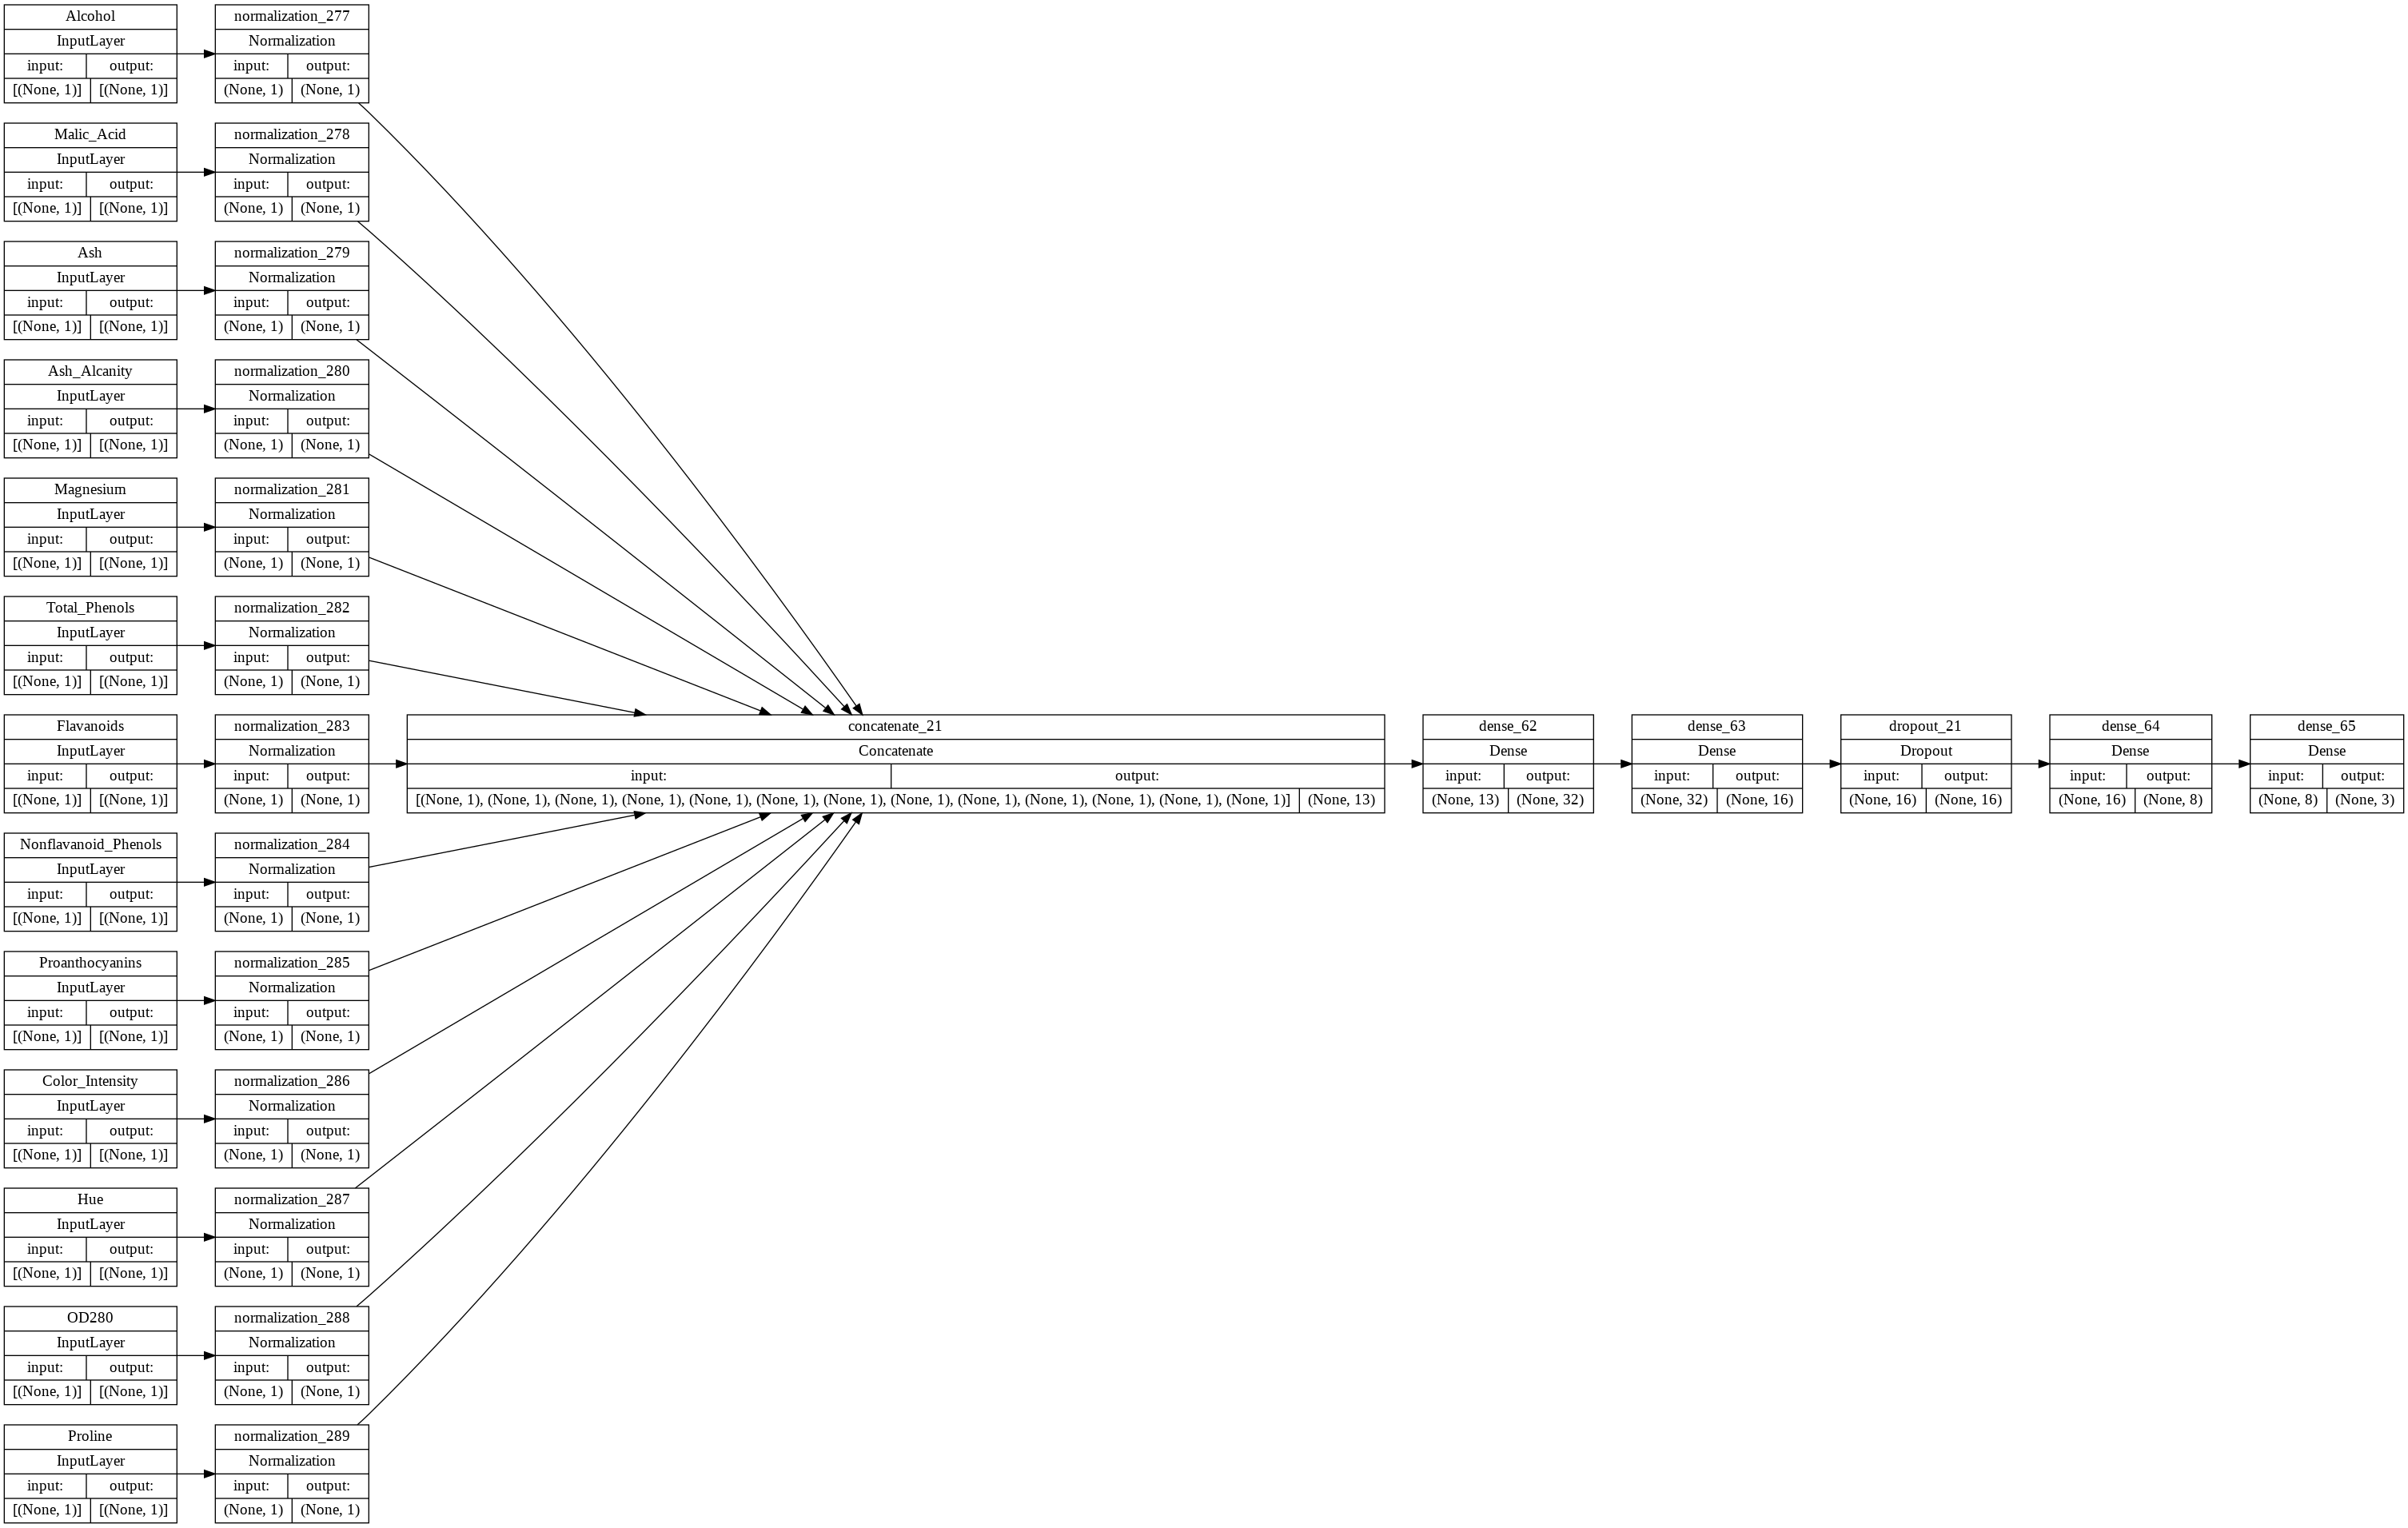

In [115]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model

In [179]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
5/5 [==============================] - 3s 120ms/step - loss: 1.8768 - accuracy: 0.1690 - val_loss: 1.6650 - val_accuracy: 0.1667
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 1.7136 - accuracy: 0.1268 - val_loss: 1.5618 - val_accuracy: 0.2500
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 1.5880 - accuracy: 0.1338 - val_loss: 1.4895 - val_accuracy: 0.3611
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 1.4998 - accuracy: 0.2324 - val_loss: 1.4353 - val_accuracy: 0.4444
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 1.4289 - accuracy: 0.2606 - val_loss: 1.3985 - val_accuracy: 0.4167
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 1.3527 - accuracy: 0.3451 - val_loss: 1.3743 - val_accuracy: 0.3333
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 1.3357 - accuracy: 0.3239 - val_loss: 1.3545 - val_accuracy: 0.4167
Epoch 8/50
5/5 [==========

We quickly get to 80% validation accuracy.

## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [ ]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 34.5 percent probability of having a heart disease, as evaluated by our model.
